This notebook demonstrates loading a DBT volume and creating the corresponding cview image.

Make sure to run: ```python download_scripts/download_volumes.py``` from ```code/``` directory before running this script.

In [1]:
import os
import numpy as np
import sys
sys.path.append(os.path.dirname(os.getcwd())) # add upper code/ directory to path 

import config_global

In [2]:
"""Function for drawing bbox on an image shown in ax"""
def draw_box(ax, box, color='r', text_label=None, linewidth=2):
    x1, y1, x2, y2 = box
    ax.plot([x1, x2], [y1, y1], color=color, linewidth=linewidth)
    ax.plot([x1, x2], [y2, y2], color=color, linewidth=linewidth)
    ax.plot([x1, x1], [y1, y2], color=color, linewidth=linewidth)
    ax.plot([x2, x2], [y1, y2], color=color, linewidth=linewidth)

    if text_label is not None:
        ax.text(x2, y1, text_label, color='r', ha='right', va='bottom', fontsize=12)

Loading DBT from raw path (without dataset):
The code below uses copied functions from the dataset definition to load an image from their raw path. This is useful for rapid visualization of new samples.

In [3]:
import re
"""Helper functions defined below"""
def read_mhd(filename):
    if 'None' in filename:
        return None
    data = {}
    with open(filename, "r") as f:
        for line in f:
            s = re.search("([a-zA-Z]*) = (.*)", line)
            data[s[1]] = s[2]

            if " " in data[s[1]]:
                data[s[1]] = data[s[1]].split(" ")
                for i in range(len(data[s[1]])):
                    if data[s[1]][i].replace(".", "").replace("-", "").isnumeric():
                        if "." in data[s[1]][i]:
                            data[s[1]][i] = float(data[s[1]][i])
                        else:
                            data[s[1]][i] = int(data[s[1]][i])
            else:
                if data[s[1]].replace(".", "").replace("-", "").isnumeric():
                    if "." in data[s[1]]:
                        data[s[1]] = float(data[s[1]])
                    else:
                        data[s[1]] = int(data[s[1]])
    return data


def read_loc(filename):
    """returns coords as [y position, x position, slice number]"""
    with open(filename, "r") as file:
        lines = file.readlines()
    coords = [int(v) for v in lines[0].strip().split(" ")[0:3]]
    return coords

def get_lesion_box(x, y, box_side=150, image_width=1324, image_height=1624, SL=10, invert_y=True):
    y = image_height - y if invert_y else y
    
    x1 = max(0, x - box_side)
    y1 = max(0, y - box_side)
    x2 = min(image_width, x + box_side + SL)
    y2 = min(image_height, y + box_side + SL)

    box = [x1, y1, x2, y2]

    return box

In [4]:
import os
import numpy as np
import sys
sys.path.append(os.path.dirname(os.getcwd())) # add upper code/ directory to path 

import config_global

raw_path = f"{config_global.dir_global}/data/volumes_subset/device_data_VICTREPhantoms_spic_1.1/fatty/2/5.0/SIM/D2_5.0_fatty.3/3/reconstruction3.raw"
box_width = 150  # pixels

# Load image
mhd_path = raw_path.replace('.raw', '.mhd')  # path + 'projection_DM1.mhd'
im_dims = read_mhd(mhd_path)['DimSize']
im_height, im_width, total_slices = int(im_dims[0]), int(im_dims[1]), int(im_dims[2])
image = np.fromfile(raw_path, dtype="float64").reshape(total_slices, im_width, im_height).astype(np.float32)
image = np.rot90(image, k=-1, axes=(-1, -2))
X = np.std(image) * 2
TH = np.mean(image)
image[image < TH - X] = 0
image[image > TH + X] = X + TH
image = (image - image.min()) / (image.max() - image.min())

# Get lesion location from loc file
loc_path = raw_path.replace('.raw', '.loc')
if os.path.exists(loc_path):
    y, x, lesion_slice = read_loc(loc_path)
    box = get_lesion_box(x, y, image_width=im_width, image_height=im_height, box_side=box_width)

(np.float64(-0.5), np.float64(1323.5), np.float64(1623.5), np.float64(-0.5))

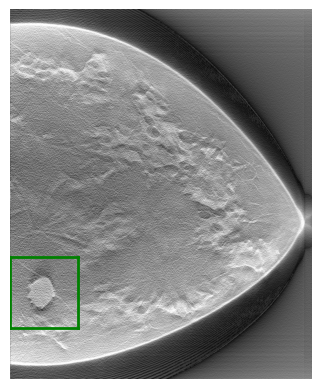

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.imshow(image[lesion_slice], cmap='gray')
draw_box(ax, box, color='g')
ax.axis('off')

Creating cview from volume: The code below synthesizes a 2D cview from the volume.

In [6]:
from scipy import signal
def get_sharpening_filter():
    """Returns sharpening filter of shape (9, 9, 9) used in Klein, et al. 2023"""
    yv, zv, xv = np.meshgrid(range(-4, 5), range(-4, 5), range(-4, 5))
    radius_square = xv ** 2 + yv ** 2 + zv ** 2
    sharpen_filter = np.zeros((9, 9, 9), dtype=np.float32)
    sharpen_filter[radius_square < 16] = 2. / 251
    sharpen_filter[(radius_square >= 16) & (radius_square < 25)] = -1./234
    return sharpen_filter


def dbt2cview(volume, sharpen_filter):
    """Approximates a 2D cview image from a 3D DBT volume using the method described in Klein, et al.
    A 2D Synthesized Image Improves the 3D Search for Foveated Visual Systems, 2023
    volume: ndarray of shape (slices, width, height)
    filter: ndarray of 3 dimensions that represents the filter kernel
    returns: ndarray of shape (width, height)"""
    image = signal.correlate(volume, sharpen_filter, mode='same', method='fft')
    return image.max(axis=0)

(np.float64(-0.5), np.float64(1323.5), np.float64(1623.5), np.float64(-0.5))

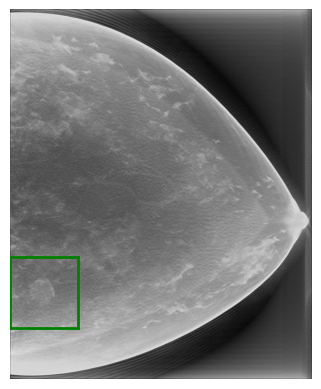

In [7]:
sharpen_filter = get_sharpening_filter()

cview = dbt2cview(image, sharpen_filter)

fig, ax = plt.subplots()
ax.imshow(cview, cmap='gray')
draw_box(ax, box, color='g')
ax.axis('off')

The full DBT dataset will be released upon acceptance. 